In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from aisynphys.database import default_db
import aisynphys.pipeline.multipatch.conductance as conductance_pipeline

In [2]:
db = default_db
session = db.session()

Select a synapse to analyze

In [3]:
# syn = db.pair_query(synapse=True, synapse_type='in', session=session)
# example_pair = syn[3]

# inhibitory
example_pair = db.pair_from_ext_id('1614212743.568', '6', '4')

# excitatory w/ failures, crosstalk
# example_pair = db.pair_from_ext_id('1625092356.185', '6', '7')

# example_pair = db.pair_from_ext_id('1596739041.999 1 6')

print(f"Selected {example_pair.synapse.synapse_type} pair {example_pair}")

psc_sign = {'in': -1, 'ex': 1}[example_pair.synapse.synapse_type]

Selected in pair <Pair 1614212743.568 6 4>


Load VC data for this synapse

In [4]:
vc_data = conductance_pipeline.get_raw_vc_data(example_pair, db, session)
if vc_data['error'] is not None:
    print(f"Error loading data: {vc_data['error']}")
    adj_holding = None
    amps = None
else:
    adj_holding = vc_data['adj_baseline']
    amps = vc_data['pr_amps']

Plot the raw data we are working with 

Text(0.5, 0, 'Time (ms)')

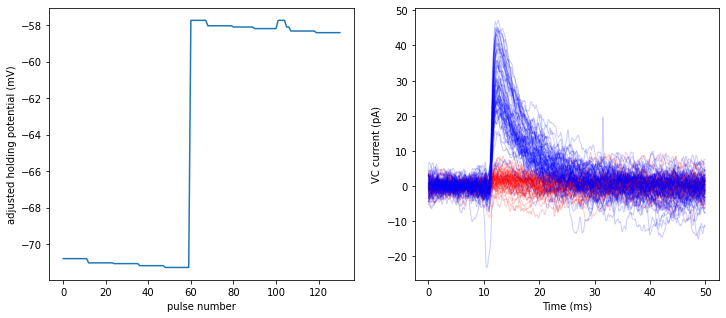

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(adj_holding * 1e3)
ax[0].set_ylabel('adjusted holding potential (mV)')
ax[0].set_xlabel('pulse number')

from neuroanalysis.filter import bessel_filter
prs = vc_data['pulse_responses']
for pr in prs:
    ts = bessel_filter(pr.post_tseries.copy(), cutoff=2e3)
    ts.t0 = 0
    baseline = ts.time_slice(0, 10e-3).data.mean()
    holding = pr.recording.patch_clamp_recording.access_adj_baseline_potential
    amp = pr.pulse_response_fit.fit_amp
    color = 'red' if holding < -60e-3 else 'blue'
    ax[1].plot(ts.time_values * 1e3, (ts.data - baseline) * 1e12, alpha=0.2, color=color, linewidth=1)
ax[1].set_ylabel('VC current (pA)')
ax[1].set_xlabel('Time (ms)')

Estimate the conductance and reversal potential 

Estimated conductance: 2.19+/-0.11 nS
Estimated reversal: -71.87+/-0.49 mV
Fit R^2: 0.7692721044203041


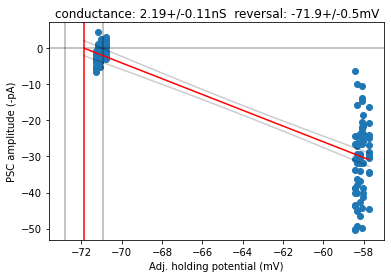

In [6]:

# plot PSC amplitudes first
fig, ax = plt.subplots()
ax.scatter(adj_holding * 1e3, amps * -1e12)
ax.set_xlabel('Adj. holding potential (mV)')
ax.set_ylabel('PSC amplitude (-pA)')

# calculate conductance and reversal potential
conductance, reversal, r2 = conductance_pipeline.calculate_conductance(amps, adj_holding, syn_type=example_pair.synapse.synapse_type)

print(f"Estimated conductance: {conductance*1e9:0.2f} nS")
print(f"Estimated reversal: {reversal*1e3:0.2f} mV")
print(f"Fit R^2: {r2}")

# plot conductance and reversal with CIs
ci_x = np.linspace(min(reversal.n, adj_holding.min()), max(reversal.n, adj_holding.max()), 100)
ci_y = conductance_pipeline.ipsc_amp_fn(ci_x, conductance, reversal)
nom = np.array([x.n for x in ci_y])
std = np.array([x.s for x in ci_y])
upper_ci = nom + 1.96 * std
lower_ci = nom - 1.96 * std

ax.set_title(f'conductance: {conductance*1e9}nS  reversal: {reversal*1e3}mV')
ax.axvline(reversal.n * 1e3, color='red')
ax.axvline((reversal.n + 1.96 * reversal.s) * 1e3, color=(0, 0, 0, 0.3))
ax.axvline((reversal.n - 1.96 * reversal.s) * 1e3, color=(0, 0, 0, 0.3))
ax.axhline(0, color=(0, 0, 0, 0.3))

ax.plot(ci_x * 1e3, nom * -1e12, color='red')
ax.plot(ci_x * 1e3, upper_ci * -1e12, color=(0, 0, 0, 0.2))
ax.plot(ci_x * 1e3, lower_ci * -1e12, color=(0, 0, 0, 0.2))


## Load conductance results from all synapses (where available)

In [7]:
import pandas
cond_df = db.query(
    db.Conductance.effective_conductance, 
    db.Conductance.reversal_potential,
    db.Conductance.meta,
    db.Synapse.synapse_type,
    db.Synapse,
).join(db.Synapse).dataframe()

# unpack meta column:
meta = pandas.DataFrame.from_records(cond_df['conductance.meta'])
cond_df = pandas.concat([cond_df, meta], axis=1)
cond_df

/home/luke/docs/aisynphys/aisynphys/database/database.py:788: SAWarning: TypeDecorator JSONObject() will not produce a cache key because the ``cache_ok`` flag is not set to True.  Set this flag to True if this type object's state is safe to use in a cache key, or False to disable this warning.
  recs = self.all()


,conductance.effective_conductance,conductance.reversal_potential,conductance.meta,synapse.synapse_type,synapse.id,synapse.pair_id,synapse.synapse_type_1,synapse.latency,synapse.psp_amplitude,synapse.psp_rise_time,synapse.psp_decay_tau,synapse.psc_amplitude,synapse.psc_rise_time,synapse.psc_decay_tau,synapse.meta,reversal_std,conductance_std,fit_r_squared
0,-4.330930e-10,-0.080441,"{'reversal_std': 0.004091654073080157, 'conduc...",ex,11,102619,ex,0.002008,0.000393,0.011445,0.033792,-4.846077e-12,0.007446,0.015686,None,0.004092,8.085453e-11,0.138813
1,3.187801e-11,0.062163,"{'reversal_std': 0.31404023576276757, 'conduct...",ex,17,63519,ex,0.001362,NaN,NaN,NaN,-2.550043e-23,0.000448,0.002390,None,0.314040,8.065046e-11,0.001322
2,1.686575e-10,-0.000112,"{'reversal_std': 0.06405107155263852, 'conduct...",ex,15,116315,ex,0.001000,NaN,NaN,NaN,-5.867870e-12,0.000769,0.002539,None,0.064051,1.676046e-10,0.009642
3,-8.018014e-11,-0.213370,"{'reversal_std': 0.34889085386361346, 'conduct...",ex,80,120501,ex,0.001199,NaN,NaN,NaN,-2.176549e-12,0.000482,0.000898,None,0.348891,1.801170e-10,0.001100
4,1.257645e-09,-0.064559,"{'reversal_std': 0.000519331308850021, 'conduc...",in,92,122917,in,0.000969,-0.000239,0.003270,0.010807,1.839777e-11,0.000828,0.002126,None,0.000519,7.924225e-11,0.540659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,2.262249e-11,0.098241,"{'reversal_std': 0.4924606100052645, 'conducta...",ex,1248,121234,ex,0.000746,NaN,NaN,NaN,-4.907465e-12,0.001159,0.010902,None,0.492461,6.949187e-11,0.000495
1451,9.016382e-11,0.031665,"{'reversal_std': 0.15915693063837363, 'conduct...",ex,1519,118723,ex,0.001085,NaN,NaN,NaN,-4.573384e-12,0.001271,0.001667,None,0.159157,1.494820e-10,0.003897
1452,-1.677629e-10,-0.098998,"{'reversal_std': 0.03626856723647999, 'conduct...",ex,1505,118720,ex,0.001578,0.000303,0.004967,0.036093,-3.509528e-12,0.000894,0.006135,None,0.036269,1.594765e-10,0.009291
1453,-7.483589e-11,-0.142969,"{'reversal_std': 0.15163285020484824, 'conduct...",ex,1364,104998,ex,0.001866,0.000033,0.003186,0.034435,-1.946543e-12,0.001445,0.011028,None,0.151633,1.438150e-10,0.001519


(array([  1.,   1.,   2.,   1.,   2.,  10.,  34.,  79., 170., 176., 135.,
         47.,  32.,  18.,  10.,  11.,   4.,   2.,   0.]),
 array([-0.09      , -0.08789474, -0.08578947, -0.08368421, -0.08157895,
        -0.07947368, -0.07736842, -0.07526316, -0.07315789, -0.07105263,
        -0.06894737, -0.06684211, -0.06473684, -0.06263158, -0.06052632,
        -0.05842105, -0.05631579, -0.05421053, -0.05210526, -0.05      ]),
 <BarContainer object of 19 artists>)

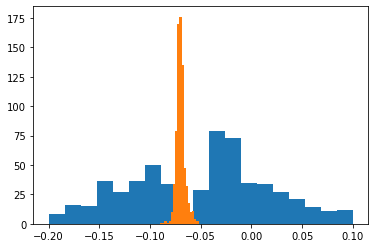

In [8]:
fig, ax = plt.subplots()
ax.hist(cond_df[cond_df['synapse.synapse_type']=='ex']['conductance.reversal_potential'], bins=np.linspace(-200e-3, 100e-3, 20))
ax.hist(cond_df[cond_df['synapse.synapse_type']=='in']['conductance.reversal_potential'], bins=np.linspace(-90e-3, -50e-3, 20))



In [9]:

# filter on fit R^2
filtered = cond_df[cond_df['fit_r_squared'] > 0.5]
filtered

,conductance.effective_conductance,conductance.reversal_potential,conductance.meta,synapse.synapse_type,synapse.id,synapse.pair_id,synapse.synapse_type_1,synapse.latency,synapse.psp_amplitude,synapse.psp_rise_time,synapse.psp_decay_tau,synapse.psc_amplitude,synapse.psc_rise_time,synapse.psc_decay_tau,synapse.meta,reversal_std,conductance_std,fit_r_squared
4,1.257645e-09,-0.064559,"{'reversal_std': 0.000519331308850021, 'conduc...",in,92,122917,in,0.000969,-0.000239,0.003270,0.010807,1.839777e-11,0.000828,0.002126,None,0.000519,7.924225e-11,0.540659
23,9.603176e-10,-0.073886,"{'reversal_std': 0.0006505107297746662, 'condu...",in,1249,24978,in,0.001010,-0.000948,0.005206,0.167647,2.432018e-11,0.001089,0.007992,None,0.000651,4.813637e-11,0.663333
27,6.898519e-10,-0.070572,"{'reversal_std': 0.0007119026364475313, 'condu...",in,1793,59673,in,0.000950,NaN,NaN,NaN,1.504303e-11,0.001504,0.005466,None,0.000712,4.678727e-11,0.648180
32,6.367097e-10,-0.063882,"{'reversal_std': 0.0005802706129227907, 'condu...",in,1848,92169,in,0.002033,-0.000894,0.009552,0.500000,1.187556e-11,0.000618,0.003935,None,0.000580,5.275235e-11,0.552488
41,6.429835e-10,-0.067686,"{'reversal_std': 0.0006399117474069737, 'condu...",in,1866,92177,in,0.001243,-0.001108,0.004505,0.069665,1.332091e-11,0.001352,0.002348,None,0.000640,5.050906e-11,0.582816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,4.121480e-10,-0.070796,"{'reversal_std': 0.0005380465293495868, 'condu...",in,1386,98282,in,0.000960,-0.001169,0.009352,0.500000,1.011087e-11,0.000328,0.000494,None,0.000538,2.659461e-11,0.584114
1397,6.470281e-10,-0.073016,"{'reversal_std': 0.0007908328604777729, 'condu...",in,2876,101571,in,0.001187,NaN,0.010841,0.491562,1.225264e-11,0.002445,0.005694,None,0.000791,4.671846e-11,0.619120
1404,3.616996e-10,-0.072069,"{'reversal_std': 0.0006841303669589757, 'condu...",in,3240,102452,in,0.001906,NaN,0.013113,0.500000,7.215239e-12,0.002743,0.008652,None,0.000684,2.573866e-11,0.525941
1409,6.391279e-10,-0.068604,"{'reversal_std': 0.0003077794646903019, 'condu...",in,3276,102427,in,0.001001,-0.001254,0.008844,0.077930,1.443759e-11,0.003502,0.009045,None,0.000308,3.047544e-11,0.729604


<AxesSubplot:xlabel='conductance.reversal_potential', ylabel='conductance.effective_conductance'>

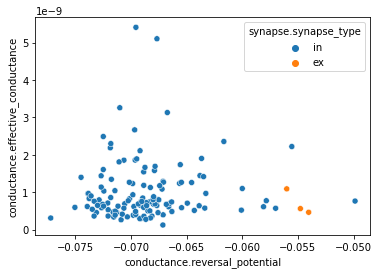

In [10]:
seaborn.scatterplot(data=filtered, x='conductance.reversal_potential', y='conductance.effective_conductance', hue='synapse.synapse_type')

In [11]:
filtered[filtered['conductance.reversal_potential'] > -60e-3]

,conductance.effective_conductance,conductance.reversal_potential,conductance.meta,synapse.synapse_type,synapse.id,synapse.pair_id,synapse.synapse_type_1,synapse.latency,synapse.psp_amplitude,synapse.psp_rise_time,synapse.psp_decay_tau,synapse.psc_amplitude,synapse.psc_rise_time,synapse.psc_decay_tau,synapse.meta,reversal_std,conductance_std,fit_r_squared
130,5.693561e-10,-0.057007,"{'reversal_std': 0.0004153621108850229, 'condu...",in,1975,66869,in,0.000834,NaN,NaN,NaN,4.193483e-12,0.001016,0.006320,None,0.000415,4.026287e-11,0.530463
193,7.713017e-10,-0.057846,"{'reversal_std': 0.0004725125054389247, 'condu...",in,1000,65019,in,0.000636,-0.000448,0.003420,0.031890,7.536934e-12,0.001564,0.007828,None,0.000473,6.661540e-11,0.507688
226,4.617854e-10,-0.054036,"{'reversal_std': 0.0007972297795804073, 'condu...",ex,2916,120187,ex,0.000575,0.000443,0.019218,0.017964,-6.570109e-12,0.001074,0.002682,None,0.000797,3.594105e-11,0.539339
322,5.602921e-10,-0.054781,"{'reversal_std': 0.0016389010936217457, 'condu...",ex,2623,68223,ex,0.002631,NaN,NaN,NaN,-1.091085e-12,0.002529,0.010319,None,0.001639,9.910014e-11,0.592332
338,1.088474e-09,-0.056009,"{'reversal_std': 0.0009257990280200935, 'condu...",ex,2750,100954,ex,0.001140,0.000298,0.005180,0.050076,-1.462868e-11,0.001988,0.006518,None,0.000926,9.354603e-11,0.534314
770,6.100085e-10,-0.058094,"{'reversal_std': 0.0004929540148684848, 'condu...",in,717,70962,in,0.000910,-0.000539,0.005145,0.037554,7.006191e-12,0.001694,0.011979,None,0.000493,4.347436e-11,0.525183
1341,2.220115e-09,-0.055551,"{'reversal_std': 0.0005177276241098889, 'condu...",in,2870,54540,in,0.000865,NaN,NaN,NaN,2.504461e-11,0.001800,0.007022,None,0.000518,1.665027e-10,0.537472
1380,7.622297e-10,-0.049865,"{'reversal_std': 0.00038667438197065204, 'cond...",in,1151,90342,in,0.001064,-0.000653,0.003527,0.023616,1.013342e-11,0.001386,0.005435,None,0.000387,6.684087e-11,0.500083
